In [1]:
# Author: Arthur Prigent
# Email: aprigent@ictp.it

In [2]:
from load_librairies import *
from scipy.stats.stats import pearsonr
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches


def nandetrend(y):
    ''' Remove the linear trend from the data '''
    
    x = np.arange(0,y.shape[0],1)
    m, b, r_val, p_val, std_err = stats.linregress(x,np.array(y))
    y_detrended= np.array(y) - m*x
    return y_detrended


def is_jja(month):
    return (month>=6) & (month<=8)


def is_f(month):
    return (month==2)
def is_mar(month):
    return (month==3)

def is_apr(month):
    return (month==4)

def is_may(month):
    return (month==5)

def is_amj(month):
    return (month>=4) & (month<=6)


dir_proj = '/home/netapp-clima-users/users/aprigent/Projects/TAV_OMIP/'
path_fig = dir_proj+'/figures_final/'

dir_forcing = '/home/clima-archive2/rfarneti/INPUT_DATA/JRA55-do-1-5-0/'
dir_tos_omip1 = '/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/'
dir_tos_omip2 = '/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/'
#dir_obs_sst = '/home/netapp-clima-users/users/aprigent/Observations/HadI-SST/'
dir_obs_sst = '/home/netapp-clima-users/users/aprigent/Observations/'
path_data_out = '/media/aprigent/Arthur_disk/data_uncertainty/'
dir_ccmp = '/media/aprigent/Arthur_disk/TAV_OMIP/'

period_str = 1985
period_end = 2004

%matplotlib inline

/tmp/ipykernel_10284/1042716884.py:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [3]:
omip1_models = pd.read_csv(dir_proj+'/scripts/omip1_models_for_BF_zos.txt',header=None,delimiter=',')
omip1_models = omip1_models[0].values.tolist()
print(omip1_models)


omip2_models = pd.read_csv(dir_proj+'/scripts/omip2_models_for_BF_zos.txt',header=None,delimiter=',')
omip2_models = omip2_models[0].values.tolist()
print(omip2_models)

['CMCC-CM2-SR5', 'CMCC-ESM2', 'EC-Earth3', 'IPSL-CM6A-LR', 'MRI-ESM2-0', 'NorESM2-LM']
['ACCESS-OM2', 'ACCESS-OM2-025', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'EC-Earth3', 'MRI-ESM2-0', 'NorESM2-LM']


# Load JRA-55 and CORE2 wind data

In [4]:
uas_jra55_atl_mon = xr.open_dataset('/media/aprigent/Arthur_disk/Data/MOM_JRA55do/JRA_uas.1958_2022_atl_monmean.nc',
                            use_cftime=True)

uas_jra55_atl_mon = uas_jra55_atl_mon.sel(time=slice(datetime(period_str, 1, 1),
                                                               datetime(period_end, 12, 31)))

In [5]:
uas_jra55_atl_arr = np.array(uas_jra55_atl_mon.uas)
uas_jra55_atl_dtd = np.ones((uas_jra55_atl_mon.uas.shape))*np.nan
for i in range(uas_jra55_atl_dtd.shape[1]):
    for j in range(uas_jra55_atl_dtd.shape[2]):
        uas_jra55_atl_dtd[:,i,j] = nandetrend(uas_jra55_atl_arr[:,i,j])

        
uas_jra55_atl_dataset = xr.Dataset({'uas_dtd': (['time','lat','lon'], uas_jra55_atl_dtd), 
    }, 
    coords={'time': np.array(uas_jra55_atl_mon.time), 
    'lat': np.array(uas_jra55_atl_mon.lat), 
    'lon': np.array(uas_jra55_atl_mon.lon)} ) 



uas_jra55_atl_dataset_monthly = uas_jra55_atl_dataset.sel(time=slice(datetime(period_str, 1, 1),
                                                               datetime(period_end, 12, 31)))

In [6]:
uasa_jra55_atl_dataset_monthly,_ = Atools.ano_norm_t(uas_jra55_atl_dataset_monthly.uas_dtd)


uasa_jra55_atl_dataset_amj = uasa_jra55_atl_dataset_monthly.sel(time=is_amj(
    uasa_jra55_atl_dataset_monthly['time.month'])).groupby('time.year').mean()

std_uasa_jra55_atl_dataset_amj = uasa_jra55_atl_dataset_amj.std(dim='year')

## CORE-II

In [7]:

uas_core2_atl_mon = xr.open_dataset('/media/aprigent/Arthur_disk/Data/CORE2/u_10_mod.1948-2007.paddednomads_atl_monmean.nc',
                            use_cftime=True)
uas_core2_atl_mon['TIME'] = uas_core2_atl_mon.indexes['TIME'].to_datetimeindex()

uas_core2_atl_mon = uas_core2_atl_mon.sel(TIME=slice(datetime(period_str, 1, 1),
                                                               datetime(period_end, 12, 31)))

/tmp/ipykernel_10284/2400160151.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  uas_core2_atl_mon['TIME'] = uas_core2_atl_mon.indexes['TIME'].to_datetimeindex()


In [8]:
uas_core2_atl_arr = np.array(uas_core2_atl_mon.U_10_MOD)
uas_core2_atl_dtd = np.ones((uas_core2_atl_mon.U_10_MOD.shape))*np.nan
for i in range(uas_core2_atl_dtd.shape[1]):
    for j in range(uas_core2_atl_dtd.shape[2]):
        uas_core2_atl_dtd[:,i,j] = nandetrend(uas_core2_atl_arr[:,i,j])

        
uas_core2_atl_dataset = xr.Dataset({'uas_dtd': (['time','lat','lon'], uas_core2_atl_dtd), 
    }, 
    coords={'time': np.array(uas_core2_atl_mon.TIME), 
    'lat': np.array(uas_core2_atl_mon.LAT), 
    'lon': np.array(uas_core2_atl_mon.LON)} ) 



uas_core2_atl_dataset_monthly = uas_core2_atl_dataset.sel(time=slice(datetime(period_str, 1, 1),
                                                               datetime(period_end, 12, 31)))

In [9]:
uasa_core2_atl_dataset_monthly,_ = Atools.ano_norm_t(uas_core2_atl_dataset_monthly.uas_dtd)

In [10]:

uasa_core2_atl_dataset_amj = uasa_core2_atl_dataset_monthly.sel(time=is_amj(
    uasa_core2_atl_dataset_monthly['time.month'])).groupby('time.year').mean()

std_uasa_core2_atl_dataset_amj = uasa_core2_atl_dataset_amj.std(dim='year')

# Load ATL4 indexes
-TAV_OMIP/scripts/processing/prepare_data_for_figure_07_uas_JRA55_COREII.ipynb

In [11]:
core2_atl4_new = xr.open_dataset(path_data_out+'u10_core2_1985_2004_new.nc')
jra5_atl4_new = xr.open_dataset(path_data_out+'u10_jra55_1985_2004_new.nc')
era5_atl4_new = xr.open_dataset(path_data_out+'u10_era5_1985_2004_new.nc')
ncep2_atl4_new = xr.open_dataset(path_data_out+'u10_ncep2_1985_2004_new.nc')
ncep_atl4_new = xr.open_dataset(path_data_out+'u10_ncep_1985_2004_new.nc')

## check ATL4-averaged UASa  timeseries

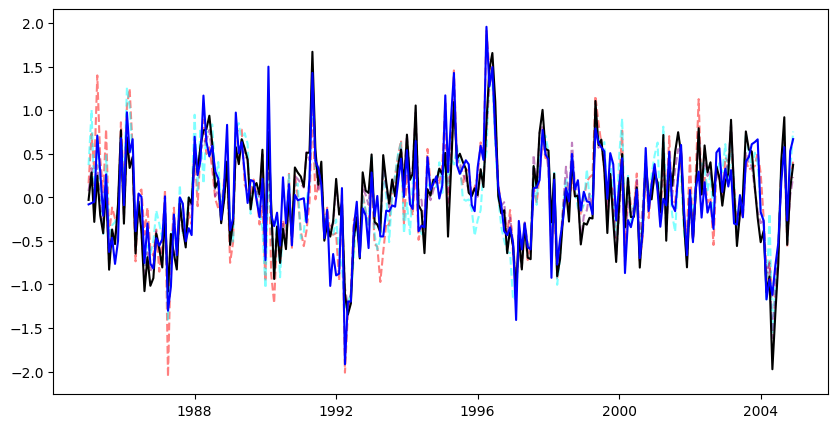

In [12]:
f,ax = plt.subplots(1,1,figsize=[10,5])


ax.plot(era5_atl4_new.time,era5_atl4_new.uasa,color='red',linestyle='--',alpha=0.5)
ax.plot(ncep2_atl4_new.time,ncep2_atl4_new.uasa,color='cyan',linestyle='--',alpha=0.5)
ax.plot(ncep_atl4_new.time,ncep_atl4_new.uasa,color='purple',linestyle='--',alpha=0.5)
ax.plot(core2_atl4_new.time,core2_atl4_new.uasa,color='black')
ax.plot(jra5_atl4_new.time,jra5_atl4_new.uasa,color='blue')

#ax.plot(ncep2_atl4.time,ncep2_atl4.uasa)
#ax.plot(ncep_atl4.time,ncep_atl4.uasa)

## CCMP

In [13]:
uwind_ccmp = xr.open_dataset(dir_ccmp+'ccmp_uwind_r360x180.nc')

uwind_ccmp = uwind_ccmp.sel(time=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))

uwind_ccmp = xr.concat([uwind_ccmp.uwnd[:,:,180:],uwind_ccmp.uwnd[:,:,:180]],dim = 'lon') 
uwind_ccmp.coords['lon'] = (uwind_ccmp.coords['lon'] + 180)%360 - 180


uwind_ccmp = uwind_ccmp.sel(time=slice(datetime(period_str, 1, 1),
                                                               datetime(period_end, 12, 31)))
uwind_ccmp = Atools.data_sub(uwind_ccmp,-40,-20,-3,3)
uwind_ccmp_arr = np.array(uwind_ccmp)
uwind_ccmp_arr_dtd = np.ones((uwind_ccmp_arr.shape))*np.nan
for i in range(uwind_ccmp_arr_dtd.shape[1]):
    for j in range(uwind_ccmp_arr_dtd.shape[2]):
        uwind_ccmp_arr_dtd[:,i,j] = nandetrend(uwind_ccmp_arr[:,i,j])

        
uwind_ccmp_atl_dataset = xr.Dataset({'uas_dtd': (['time','lat','lon'], uwind_ccmp_arr_dtd), 
    }, 
    coords={'time': np.array(uwind_ccmp.time), 
    'lat': np.array(uwind_ccmp.lat), 
    'lon': np.array(uwind_ccmp.lon)} ) 



uwind_ccmp_atl_dataset_monthly = uwind_ccmp_atl_dataset.sel(time=slice(datetime(period_str, 1, 1),
                                                               datetime(period_end, 12, 31)))






In [14]:
uwinda_ccmp_atl4_dtd,_ = Atools.ano_norm_t(uwind_ccmp_atl_dataset_monthly.uas_dtd)

In [15]:
uwinda_ccmp_atl4_dtd_mean = uwinda_ccmp_atl4_dtd.weighted(
        np.cos(np.deg2rad(uwinda_ccmp_atl4_dtd.lat))).mean(('lon','lat'))


uwind_ccmp_atl_dataset_monthly_atl4_mean = uwind_ccmp_atl_dataset_monthly.weighted(
        np.cos(np.deg2rad(uwind_ccmp_atl_dataset_monthly.lat))).mean(('lon','lat'))

In [16]:

clim_uwind_ccmp_atl4 = uwind_ccmp_atl_dataset_monthly_atl4_mean.uas_dtd.groupby('time.month').mean()



In [17]:
std_uwinda_ccmp_atl4_dtd = uwinda_ccmp_atl4_dtd_mean.groupby('time.month').std()

# Figure 8

/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


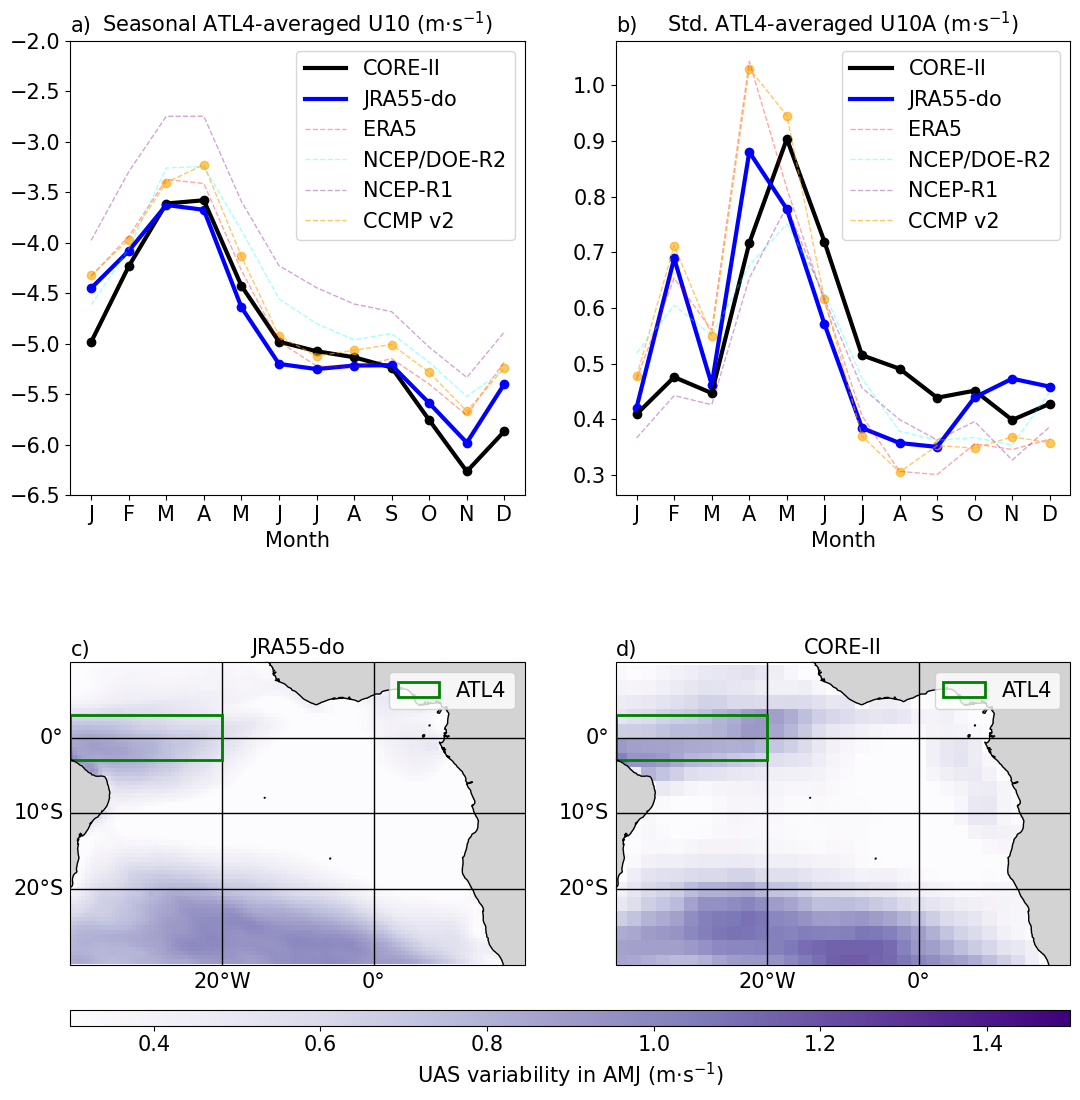

In [18]:
fig = plt.figure(figsize=[10,10])
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(2,2)
ftz=15
m = np.arange(1,13,1)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
#ax4 = fig.add_subplot(gs[1,:])

ax2 = fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[1,1],projection=ccrs.PlateCarree())
cmap = plt.cm.Purples
levels = np.arange(0.3,2,0.1)

alpha = 0.35
month = ['J','F','M','A','M','J','J','A','S','O','N','D']
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.2, wspace=0.2)



cax0 = inset_axes(ax2,
                 width='220%',
                 height='5%',
                 loc = 'lower left',
                 bbox_to_anchor=(0,-0.2,1,1),
                 bbox_transform=ax2.transAxes,
                 borderpad=0)




ax0.plot(m,core2_atl4_new.clim_uas,color='black',linewidth=3,label='CORE-II')
ax0.scatter(m,core2_atl4_new.clim_uas,color='black')

ax0.plot(m,jra5_atl4_new.clim_uas,color='blue',linewidth=3,label='JRA55-do')
ax0.scatter(m,jra5_atl4_new.clim_uas,color='blue')
ax0.plot(m,era5_atl4_new.clim_uas,color='red',linewidth=1,label='ERA5',alpha=alpha,linestyle='--')
ax0.plot(m,ncep2_atl4_new.clim_uas,color='cyan',linewidth=1,label='NCEP/DOE-R2',alpha=alpha,linestyle='--')
ax0.plot(m,ncep_atl4_new.clim_uas,color='purple',linewidth=1,label='NCEP-R1',alpha=alpha,linestyle='--')
ax0.plot(m,clim_uwind_ccmp_atl4,color='orange',linewidth=1,label='CCMP v2',alpha=0.6,linestyle='--')
ax0.scatter(m,clim_uwind_ccmp_atl4,color='orange',alpha=0.6)
ax0.set_xticks(m)
ax0.set_xticklabels(month,fontsize=ftz)
ax0.tick_params(labelsize=ftz)
ax0.set_title('Seasonal ATL4-averaged U10 (m$\cdot$s$^{-1}$)',fontsize=ftz)
ax0.legend(fontsize=ftz)
ax0.set_ylim([-6.5,-2])
ax0.set_xlabel('Month',fontsize=ftz)





ax1.plot(m,core2_atl4_new.std_uasa,color='black',linewidth=3,label='CORE-II')
ax1.scatter(m,core2_atl4_new.std_uasa,color='black')
ax1.plot(m,jra5_atl4_new.std_uasa,color='blue',linewidth=3,label='JRA55-do')
ax1.scatter(m,jra5_atl4_new.std_uasa,color='blue')
ax1.plot(m,era5_atl4_new.std_uasa,color='red',linewidth=1,label='ERA5',alpha=alpha,linestyle='--')
ax1.plot(m,ncep2_atl4_new.std_uasa,color='cyan',linewidth=1,label='NCEP/DOE-R2',alpha=alpha,linestyle='--')
ax1.plot(m,ncep_atl4_new.std_uasa,color='purple',linewidth=1,label='NCEP-R1',alpha=alpha,linestyle='--')
ax1.plot(m,std_uwinda_ccmp_atl4_dtd,color='orange',linewidth=1,label='CCMP v2',alpha=0.6,linestyle='--')
ax1.scatter(m,std_uwinda_ccmp_atl4_dtd,color='orange',alpha=0.6)
ax1.set_xticks(m)
ax1.set_xticklabels(month,fontsize=ftz)
ax1.tick_params(labelsize=ftz)
ax1.set_title('Std. ATL4-averaged U10A (m$\cdot$s$^{-1}$)',fontsize=ftz)
ax1.legend(fontsize=ftz)
ax1.set_xlabel('Month',fontsize=ftz)





p0 = ax2.pcolor(std_uasa_jra55_atl_dataset_amj.lon,
               std_uasa_jra55_atl_dataset_amj.lat,
               std_uasa_jra55_atl_dataset_amj,
               cmap = cmap,vmin=0.3,vmax=1.5,transform=ccrs.PlateCarree())

ax2.add_patch(mpatches.Rectangle(xy=[-40,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='green',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL4'))


gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=1,
                  linestyle='-',zorder=1)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': ftz, 'color': 'black'}
gl.ylabel_style = {'size': ftz, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-40,-20,0,20])
gl.ylocator = mticker.FixedLocator([-20,-10,0,10])
ax2.add_feature(cartopy.feature.COASTLINE,zorder=3)# add coastlines
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=1)# add coastlines
ax2.set_xlim([-40,20])
ax2.set_ylim([-30,10])
ax2.set_title('JRA55-do',fontsize=ftz)
ax2.legend(fontsize=ftz)
cbar = plt.colorbar(p0,cax0,orientation='horizontal')
cbar.ax.tick_params(labelsize=ftz)
cbar.set_label('UAS variability in AMJ (m$\cdot$s$^{-1}$)',fontsize=ftz)




p0 = ax3.pcolor(std_uasa_core2_atl_dataset_amj.lon,
               std_uasa_core2_atl_dataset_amj.lat,
               std_uasa_core2_atl_dataset_amj,
               cmap = cmap,vmin=0.3,vmax=1.5,transform=ccrs.PlateCarree())

ax3.add_patch(mpatches.Rectangle(xy=[-40,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='green',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL4'))


gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=1,
                  linestyle='-',zorder=1)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': ftz, 'color': 'black'}
gl.ylabel_style = {'size': ftz, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-40,-20,0,20])
gl.ylocator = mticker.FixedLocator([-20,-10,0,10])
ax3.add_feature(cartopy.feature.COASTLINE,zorder=3)# add coastlines
ax3.add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=1)# add coastlines
ax3.set_xlim([-40,20])
ax3.set_ylim([-30,10])
ax3.set_title('CORE-II',fontsize=ftz)
ax3.legend(fontsize=ftz)


#ax4.axhline(0,color='black',linestyle='--')
#ax4.plot(core2_atl4_new.time,core2_atl4_new.uasa,color='black',linewidth=3)
#ax4.plot(jra5_atl4_new.time,jra5_atl4_new.uasa,color='blue',linewidth=3)
#ax4.plot(era5_atl4_new.time,era5_atl4_new.uasa,color='red',linewidth=1,alpha=alpha,linestyle='--')

#ax4.plot(ncep2_atl4_new.time,ncep2_atl4_new.uasa,color='cyan',linewidth=1,alpha=alpha,linestyle='--')
#ax4.plot(ncep_atl4_new.time,ncep_atl4_new.uasa,color='purple',linewidth=1,alpha=alpha,linestyle='--')
#ax4.plot(uwinda_ccmp_atl4_dtd_mean.time,uwinda_ccmp_atl4_dtd_mean,
#         color='orange',linewidth=3,alpha=alpha,linestyle='--')
#ax4.tick_params(labelsize=ftz)
#ax4.set_title('ATL4-averaged U10A (m$\cdot$s$^{-1}$)',fontsize=ftz)


ax0.text(0,1.02,'a)',transform=ax0.transAxes,size=ftz)
ax1.text(0,1.02,'b)',transform=ax1.transAxes,size=ftz)
#ax4.text(0,1.02,'c)',transform=ax4.transAxes,size=ftz)
ax2.text(0,1.02,'c)',transform=ax2.transAxes,size=ftz)
ax3.text(0,1.02,'d)',transform=ax3.transAxes,size=ftz)

plt.savefig(path_fig+'figure_08.png',bbox_inches='tight',dpi=300)

In [19]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


In [20]:
print('RMSE climatology CORE-II and CCMP v2 = ',np.round(rmse(core2_atl4_new.clim_uas.values,
                                                  clim_uwind_ccmp_atl4.values),2),'m/s')

print('RMSE climatology JRA55-do and CCMP v2 = ',np.round(rmse(jra5_atl4_new.clim_uas.values,
                                                  clim_uwind_ccmp_atl4.values),2),'m/s')



print('RMSE climatology std CORE-II and CCMP v2 = ',np.round(rmse(core2_atl4_new.std_uasa.values,
                                                  std_uwinda_ccmp_atl4_dtd.values),2),'m/s')

print('RMSE climatology std JRA55-do and CCMP v2 = ',np.round(rmse(jra5_atl4_new.std_uasa.values,
                                                  std_uwinda_ccmp_atl4_dtd.values),2),'m/s')

RMSE climatology CORE-II and CCMP v2 =  0.39 m/s
RMSE climatology JRA55-do and CCMP v2 =  0.27 m/s
RMSE climatology std CORE-II and CCMP v2 =  0.15 m/s
RMSE climatology std JRA55-do and CCMP v2 =  0.09 m/s
